## CTR Analysis – A/B Test of Control vs Test Group

### Table of Contents
#### 1. **Introduction**
#### 2. **Exploratory Data Analysis - EDA**
#### 3. **Statistical Analysis**
#### 4. **Conclusion**

### 1. Introduction
In digital products, measuring user engagement is critical for evaluating the effectiveness of design changes, features, or marketing efforts. One of the most widely used metrics for this purpose is the **Click-Through Rate (CTR)** — the ratio of clicks to views — which directly reflects how effectively users interact with available content.

This project presents the results of an A/B test designed to compare the CTR performance between two groups: a control group exposed to the existing version of a product and a test group that received a new variant. The goal of the test was to assess whether the new variant leads to a statistically and practically significant increase in user engagement, as measured by CTR.

The analysis includes data preprocessing, metric computation, statistical testing, and confidence interval visualization to determine the significance and size of the effect. The results will help guide decisions on whether to roll out the test variant more broadly.

### 2. Exploratory Data Analysis - EDA

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()
plt.style.use('bmh')

In [3]:
df=pd.read_csv(r'C:\Users\dorot\Downloads\AB testing\AB_Clicks.csv')
df.head()

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  120000 non-null  int64  
 1   group    120000 non-null  object 
 2   views    120000 non-null  float64
 3   clicks   120000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [7]:
df.describe()

,user_id,views,clicks
count,120000.000000,120000.000000,120000.000000
mean,60000.500000,4.991075,0.182692
std,34641.160489,5.915200,0.472547
min,1.000000,1.000000,0.000000
25%,30000.750000,2.000000,0.000000
50%,60000.500000,3.000000,0.000000
75%,90000.250000,6.000000,0.000000
max,120000.000000,205.000000,9.000000


In [9]:
df.isnull().sum()

user_id    0
group      0
views      0
clicks     0
dtype: int64

In [11]:
df[df.duplicated(subset='user_id')]

,user_id,group,views,clicks


Dataset doesn't have any null or duplicated values.

In [19]:
print('Unique groups: ', df['group'].unique())
df.group.value_counts()

Unique groups:  ['control' 'test']


group
control    60000
test       60000
Name: count, dtype: int64

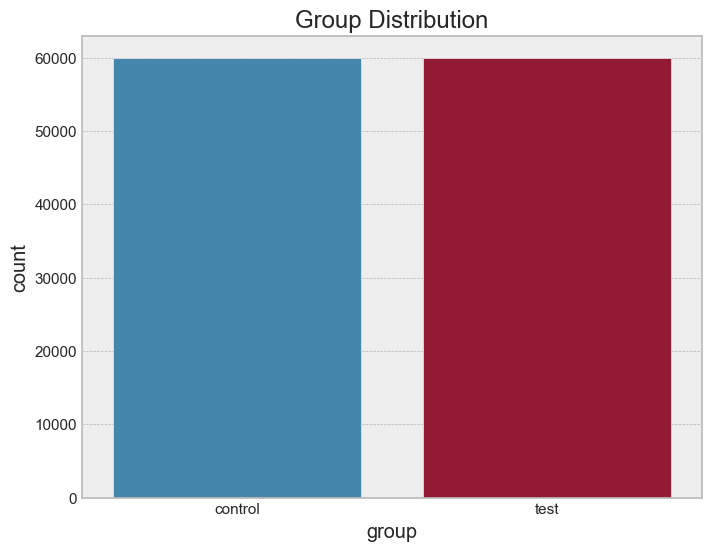

In [41]:
plt.figure(figsize=(8,6))
sns.countplot(data=df,x='group',hue='group')
plt.title('Group Distribution')
plt.show()

We will be working with 2 groups, **control** group, exposed to the existing version of products, and **test** group, with the new variant.

In [6]:
df['ctr']=df['clicks']/df['views']
df.head()

,user_id,group,views,clicks,ctr
0,1,control,10.0,0.0,0.0
1,2,control,1.0,0.0,0.0
2,3,control,1.0,0.0,0.0
3,4,control,2.0,0.0,0.0
4,5,control,3.0,0.0,0.0


To evaluate user engagement across the control and test groups, we created a new metric called **Click-Through Rate (CTR)**. CTR is defined as the **number of clicks divided by the number of views** for each user.

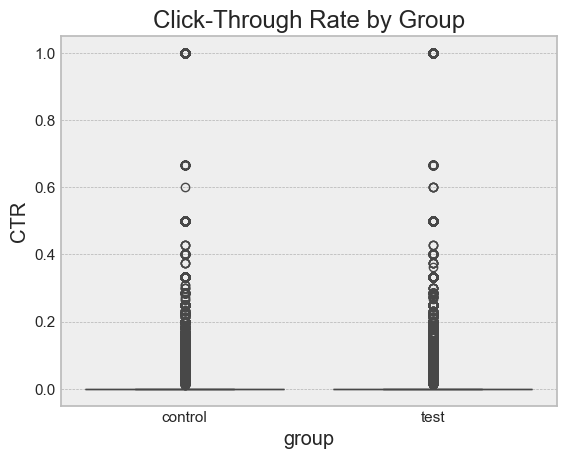

In [8]:
sns.boxplot(x='group', y='ctr', data=df)
plt.title('Click-Through Rate by Group')
plt.ylabel('CTR')
plt.show()

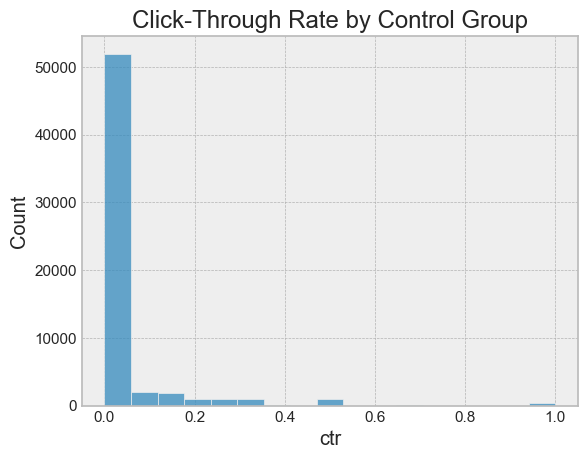

In [61]:
sns.histplot(x='ctr', data=df[df['group']=='control'])
plt.title('Click-Through Rate by Control Group')
plt.show()

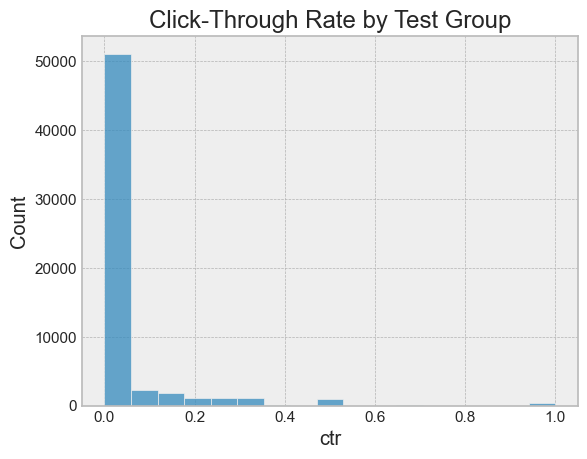

In [63]:
sns.histplot(x='ctr', data=df[df['group']=='test'])
plt.title('Click-Through Rate by Test Group')
plt.show()

The boxplot displays the distribution of Click-Through Rate (CTR) for both control and test groups. While most users in both groups have a CTR near zero, a small number of users exhibit high engagement, with CTRs approaching 1. These outliers are more visible in the test group, indicating potential variance in user behavior. However, due to the heavy skew and presence of extreme values, we rely on mean CTR and statistical testing to draw more reliable conclusions.

### 3. Statistical Analysis

In [12]:
mean_control = df.groupby('group')['ctr'].mean().loc['control']
mean_test = df.groupby('group')['ctr'].mean().loc['test']
print("Average CTR for Control group: ",round(mean_control,4))
print("Average CTR for Test group: ",round(mean_test,4))
lift=((mean_test-mean_control)/mean_control)*100
print(f"Relative lift: {round(lift,2)}%")

Average CTR for Control group:  0.0347
Average CTR for Test group:  0.0386
Relative lift: 11.52%


The mean Click-Through Rate (CTR) for the control group was **3.47%**, while the test group achieved a higher mean CTR of **3.86%**. This represents an approximate **11.52%** lift in average CTR for users exposed to the test variant. While promising, we conducted further statistical testing to determine if this difference is significant and not due to random variation.

#### Mann-Whitney U test

Distribution of CTR shows that data is highly skewed and contains many zeros, which indicates a non-normal distribution. Because of that, for this analysis we are going to use **Mann-Whiyney U test**, which does not assume normality and compares medians and distribution.

In [14]:
from scipy.stats import mannwhitneyu

ctr_control = df[df['group'] == 'control']['ctr']
ctr_test = df[df['group'] == 'test']['ctr']

stat, p = mannwhitneyu(ctr_control, ctr_test, alternative='two-sided')
print(f'Mann-Whitney U p-value: {p:.15f}')
alpha = 0.05
if p < alpha:
    print('Statistically significant difference in CTR between groups.')
else:
    print('No statistically significant difference in CTR.')

Mann-Whitney U p-value: 0.000000000000826
Statistically significant difference in CTR between groups.


The results showed p-value of around **0.000000000000826**, which is far below our standard significance level of 0.5 indicating that the difference in CTR distributions between the groups is **statistically significant**. There's strong evidence that the test group has a different (and higher) CTR than the control group. With this result, we can drop the null hypotesis.

#### Welch’s t-test

In [16]:
from scipy.stats import ttest_ind

ctr_control = df[df['group'] == 'control']['ctr']
ctr_test = df[df['group'] == 'test']['ctr']

t_stat, p_val = ttest_ind(ctr_test, ctr_control, equal_var=False)
print(f'T-statistic: {t_stat:.3f}')
print(f'P-value: {p_val:.9f}')

alpha = 0.05
if p_val < alpha:
    print('Statistically significant difference in CTR between groups.')
else:
    print('No statistically significant difference in CTR.')


T-statistic: 5.871
P-value: 0.000000004
Statistically significant difference in CTR between groups.


The results showed a T-statistic of **5.871** and a p-value less than **0.001**, indicating that the difference in mean CTRs between the groups is statistically significant at the 95% confidence level. This supports the hypothesis that the test variant led to increased user engagement.

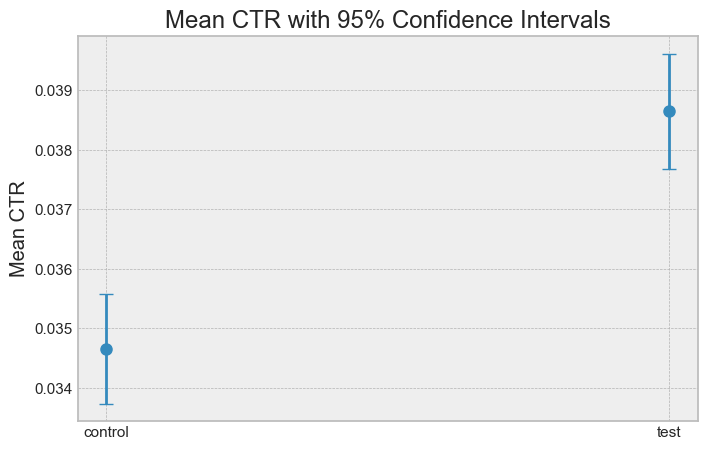

In [18]:
summary = df.groupby('group')['ctr'].agg(['mean', 'count', 'std']).reset_index()
summary['se'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = 1.96 * summary['se']

plt.figure(figsize=(8, 5))
plt.errorbar(summary['group'], summary['mean'], yerr=summary['ci95'], fmt='o', capsize=5, markersize=8)
plt.title('Mean CTR with 95% Confidence Intervals')
plt.ylabel('Mean CTR')
plt.grid(True)
plt.show()

This chart displays the mean Click-Through Rate (CTR) for both the control and test groups, along with their 95% confidence intervals.
The test group shows a visibly higher mean CTR compared to the control group, and the confidence intervals do not overlap, suggesting the difference is statistically significant.
This supports the conclusion from the Welch’s t-test that the test version performed significantly better in terms of CTR.

### 5. Conclusion

The A/B test results show a statistically significant improvement in CTR for the **test group**.
Both Welch’s t-test and the Mann-Whitney U test provide strong evidence that the difference in CTR between the groups is statistically significant and not due to random variation.
With a relative CTR lift of **+11.52%**, the test variant can be considered more effective in engaging users.
Given the significance of the results and practical impact, it is recommend adopting the test variant as the new default.